<a href="https://colab.research.google.com/github/abhinavj98/machine-learning/blob/master/denoising_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
# tf.compat.v1.disable_eager_execution()

In [ ]:
im_shape = (32,32,3)
batch_size = 64

In [ ]:
def add_gaussian_noise(data, std):
    noise = tf.random.normal(shape = im_shape, mean = 0.0, stddev = std, dtype = tf.float32) 
    new_data = data + noise
    new_data = tf.clip_by_value(new_data, clip_value_min=-1, clip_value_max=1)
    return new_data

def add_poisson_noise(data, lam):
    noise = tf.random.poisson(im_shape, lam, dtype=tf.dtypes.float32)
    new_data = data + noise
    new_data = tf.clip_by_value(new_data, clip_value_min=-1, clip_value_max=1)
    return new_data

In [ ]:
(x, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

print("Training set : ",x.shape)
print("Test set : ",x_test.shape)

Training set :  (50000, 32, 32, 3)
Test set :  (10000, 32, 32, 3)


In [ ]:
# Normalizing date to fit between -1 and 1
train_dataset = tf.data.Dataset.from_tensor_slices((x)).map(lambda x: x/255.0)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test)).map(lambda x: x/255.0)

In [ ]:
# Adding Noise
# train_dataset_gauss1 = train_dataset.map(lambda x: add_gaussian_noise(x,0.1))
# train_dataset_gauss2 = train_dataset.map(lambda x: add_gaussian_noise(x,0.2))
train_dataset_poiss1 = train_dataset.map(lambda x: add_poisson_noise(x,0.05))
train_dataset_poiss2 = train_dataset.map(lambda x: add_poisson_noise(x,0.1))
test_dataset_poiss1 = test_dataset.map(lambda x: add_poisson_noise(x,0.05))
test_dataset_poiss2 = test_dataset.map(lambda x: add_poisson_noise(x,0.1))

In [ ]:
#Creating the dataset to train on
# train_dataset_noisy = train_dataset_gauss1.concatenate(train_dataset_poiss2).concatenate(train_dataset_poiss1).concatenate(train_dataset_gauss2)
train_dataset_noisy = train_dataset_poiss1.concatenate(train_dataset_poiss2)
train_dataset_noisy = tf.data.Dataset.zip((train_dataset_noisy, train_dataset.repeat(2)))
train_dataset_noisy = train_dataset_noisy.shuffle(100000)

test_dataset_noisy = test_dataset_poiss1.concatenate(test_dataset_poiss2)
test_dataset_noisy = tf.data.Dataset.zip((test_dataset_noisy, test_dataset.repeat(2)))
test_dataset_noisy = test_dataset_noisy.shuffle(20000)

# print(len(list(train_dataset_noisy)), len(list(test_dataset_noisy)))

In [ ]:
#Visualising
num_exam = 5
pad = 5
fig, axes = plt.subplots(nrows = num_exam,  ncols = 2, figsize = (20,20))
axes[0][0].set_title("Noisy Image")
axes[0][1].set_title("Original Image")
for j,i in enumerate(train_dataset_noisy.take(num_exam)):
  axes[j][0].imshow(tf.squeeze((i[0])))
  axes[j][1].imshow(tf.squeeze((i[1])))

In [ ]:
num_exam = 5
pad = 5
fig, axes = plt.subplots(nrows = num_exam,  ncols = 2, figsize = (20,20))
axes[0][0].set_title("Noisy Image")
axes[0][1].set_title("Original Image")
for j,i in enumerate(test_dataset_noisy.take(num_exam)):
  axes[j][0].imshow(tf.squeeze((i[0])))
  axes[j][1].imshow(tf.squeeze((i[1])))

In [ ]:
train_dataset_noisy = train_dataset_noisy.batch(batch_size = batch_size)
test_dataset_noisy = test_dataset_noisy.batch(batch_size = batch_size)


In [ ]:
z_dim = 4096
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/drive/My Drive/dae")
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
file_writer = tf.summary.create_file_writer(logdir="/content/drive/My Drive/dae")

class vae(keras.Model):
  def __init__(self, z_dim, **kwargs):
    super(vae, self).__init__(**kwargs)
    self.original_dim = 32*32
    self.z_dim = z_dim
    # self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    self.encoder = self.make_encoder()
    self.decoder = self.make_decoder()

  def convblock(self,x, filters, kernel):
    for i in range(2):
      x = layers.Conv2D(filters, (kernel, kernel), padding='same',activation=tf.keras.layers.LeakyReLU())(x)
      x = layers.BatchNormalization()(x)
    return x
  def reduceblock(self,x,filters):
    x = layers.Conv2D(filters, (3, 3), padding='same',activation=tf.keras.layers.LeakyReLU(), strides = 2)(x)
    x = layers.BatchNormalization()(x)
    return x

  def make_encoder(self):
    inputs = layers.Input(shape=(32,32,3))
    x = self.convblock(inputs, 16, 5) #32,32,16
    x = self.reduceblock(x,16) #16,16,16
    x = self.convblock(x, 32, 3) #16,16,32
    x = self.reduceblock(x,32) #8,8,32
    x = self.convblock(x, 64, 3) #8,8,64
    # x = self.reduceblock(x,64) #4,4,32
    x = layers.Flatten()(x)
    z_mean_log_var = layers.Dense(2*self.z_dim)(x)
    z_mean, z_log_var = tf.split(z_mean_log_var, num_or_size_splits=2, axis=1)
    encoded = layers.Lambda(self.sampling, output_shape = (self.z_dim,))([z_mean, z_log_var])
    encoder_mod = keras.Model(inputs, [z_mean, z_log_var, encoded])
    return encoder_mod

  def make_decoder(self):
    encoded = keras.Input(shape = (self.z_dim,))
    # z = layers.Dense(8*8*64)(encoded)
    z = layers.Reshape((8,8,64))(encoded)
    z = self.convblock(z, 64, 3) # 8, 8, 32
    z = layers.UpSampling2D(size = 2)(z)  # 16,16,32
    z = self.convblock(z, 16, 3) # 16, 16, 16
    z = layers.UpSampling2D(size = 2)(z) # 32,32,316
    z = self.convblock(z, 8, 3) # 32,32,8
    # z = layers.UpSampling2D(size = 2)(z) # 32,32,8
    logits  = self.convblock(z, 3, 3) # 32,32,3  
    img = layers.Activation(tf.nn.sigmoid)(logits)
    decoder_mod = keras.Model(inputs = encoded, outputs = img)
    return decoder_mod

  def train_step(self, data):
      # if isinstance(data, tuple):
      #     data = data[0]
      with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(data[0])
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data[1], reconstruction))
          reconstruction_loss *= self.original_dim
          kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
          kl_loss = tf.reduce_mean(kl_loss)
          kl_loss *= -0.5
          total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }
    
  def test_step(self, data):
    z_mean, z_log_var, z = self.encoder(data[0])
    reconstruction = self.decoder(z)
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(data[1], reconstruction)
    )
    reconstruction_loss *= self.original_dim
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    total_loss = reconstruction_loss + kl_loss
    print(tf.shape(data))
    return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }

  def sampling(self, args):
      z_mean, z_log_var = args
      epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.z_dim))
      return z_mean + tf.exp(z_log_var / 2) * epsilon + 0.001

  def call(self, data):
    z_mean, z_log_var, z = self.encoder(data)
    reconstruction = self.decoder(z)
    return reconstruction


In [ ]:
denoise_vae = vae(z_dim)
denoise_vae.encoder.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   1216        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 32, 32, 16)   6416        batch_normalization_64[0][0]     
____________________________________________________________________________________________

In [ ]:
denoise_vae.decoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_72 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_73 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 16, 16, 64)        0   

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/dae/checkpoint'
denoise_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
restore = False
if restore:
  denoise_vae.load_weights(checkpoint_filepath)
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs=None):
        if epoch%5==0:
          for i in test_dataset_noisy.take(1):
            op = denoise_vae(tf.expand_dims(i[0][0], axis = 0)).numpy()
            plt.subplot(1,3,1)
            plt.imshow(np.squeeze(op[0]))
            plt.subplot(1,3,2)
            plt.imshow(np.squeeze(i[0][0].numpy()))
            plt.subplot(1,3,3)
            plt.imshow(np.squeeze(i[1][0].numpy()))
            plt.show()
            break

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, save_freq = 5*1563)

# CustomCallback().on_epoch_end(1)

Epoch 1/25
1563/1563 [==============================] - ETA: 0s - loss: 595.4842 - reconstruction_loss: 594.5574 - kl_loss: 0.9268Tensor("Shape:0", shape=(5,), dtype=int32)


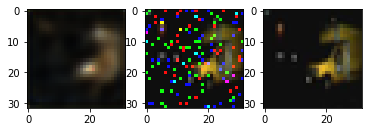

1563/1563 [==============================] - 48s 31ms/step - loss: 595.4614 - reconstruction_loss: 594.5344 - kl_loss: 0.9269 - val_loss: 600.1417 - val_reconstruction_loss: 599.1351 - val_kl_loss: 1.0065
Epoch 2/25
1563/1563 [==============================] - 43s 27ms/step - loss: 579.1635 - reconstruction_loss: 578.1598 - kl_loss: 1.0037 - val_loss: 576.1907 - val_reconstruction_loss: 575.2300 - val_kl_loss: 0.9608
Epoch 3/25
1563/1563 [==============================] - 43s 28ms/step - loss: 575.9333 - reconstruction_loss: 575.0499 - kl_loss: 0.8834 - val_loss: 576.0450 - val_reconstruction_loss: 575.2560 - val_kl_loss: 0.7889
Epoch 4/25
1563/1563 [==============================] - 43s 27ms/step - loss: 573.8226 - reconstruction_loss: 573.0611 - kl_loss: 0.7615 - val_loss: 592.8668 - val_reconstruction_loss: 592.1885 - val_kl_loss: 0.6782
Epoch 5/25
1563/1563 [==============================] - 45s 29ms/step - loss: 572.4366 - reconstruction_loss: 571.7615 - kl_loss: 0.6751 - val_loss

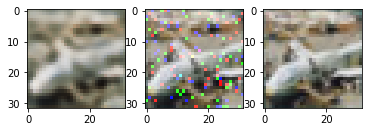

1563/1563 [==============================] - 47s 30ms/step - loss: 571.5869 - reconstruction_loss: 570.9622 - kl_loss: 0.6247 - val_loss: 579.0919 - val_reconstruction_loss: 578.4919 - val_kl_loss: 0.6000
Epoch 7/25
1563/1563 [==============================] - 43s 28ms/step - loss: 570.9124 - reconstruction_loss: 570.3151 - kl_loss: 0.5973 - val_loss: 572.2723 - val_reconstruction_loss: 571.7023 - val_kl_loss: 0.5700
Epoch 8/25
1563/1563 [==============================] - 43s 27ms/step - loss: 570.4482 - reconstruction_loss: 569.8650 - kl_loss: 0.5832 - val_loss: 569.2360 - val_reconstruction_loss: 568.6403 - val_kl_loss: 0.5957
Epoch 9/25
1563/1563 [==============================] - 43s 28ms/step - loss: 569.8883 - reconstruction_loss: 569.3026 - kl_loss: 0.5857 - val_loss: 553.8765 - val_reconstruction_loss: 553.2729 - val_kl_loss: 0.6036
Epoch 10/25
1563/1563 [==============================] - 45s 29ms/step - loss: 569.2824 - reconstruction_loss: 568.6832 - kl_loss: 0.5991 - val_los

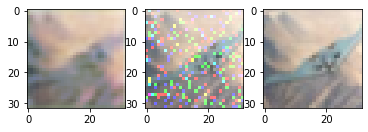

1563/1563 [==============================] - 47s 30ms/step - loss: 568.3670 - reconstruction_loss: 567.7418 - kl_loss: 0.6252 - val_loss: 561.0269 - val_reconstruction_loss: 560.3490 - val_kl_loss: 0.6779
Epoch 12/25
1563/1563 [==============================] - 43s 28ms/step - loss: 567.1339 - reconstruction_loss: 566.4874 - kl_loss: 0.6465 - val_loss: 593.7224 - val_reconstruction_loss: 593.1274 - val_kl_loss: 0.5949
Epoch 13/25
1563/1563 [==============================] - 43s 27ms/step - loss: 566.3691 - reconstruction_loss: 565.7189 - kl_loss: 0.6502 - val_loss: 565.3165 - val_reconstruction_loss: 564.6626 - val_kl_loss: 0.6539
Epoch 14/25
1563/1563 [==============================] - 43s 27ms/step - loss: 565.8949 - reconstruction_loss: 565.2427 - kl_loss: 0.6522 - val_loss: 557.3109 - val_reconstruction_loss: 556.6505 - val_kl_loss: 0.6604
Epoch 15/25
1563/1563 [==============================] - 45s 29ms/step - loss: 565.4703 - reconstruction_loss: 564.8164 - kl_loss: 0.6539 - val_

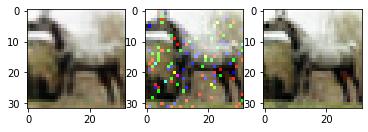

1563/1563 [==============================] - 47s 30ms/step - loss: 565.1412 - reconstruction_loss: 564.4881 - kl_loss: 0.6531 - val_loss: 550.3603 - val_reconstruction_loss: 549.6954 - val_kl_loss: 0.6648
Epoch 17/25
1563/1563 [==============================] - 43s 28ms/step - loss: 564.8344 - reconstruction_loss: 564.1828 - kl_loss: 0.6516 - val_loss: 546.7381 - val_reconstruction_loss: 546.0680 - val_kl_loss: 0.6701
Epoch 18/25
1563/1563 [==============================] - 43s 27ms/step - loss: 564.5672 - reconstruction_loss: 563.9180 - kl_loss: 0.6493 - val_loss: 579.6566 - val_reconstruction_loss: 579.0265 - val_kl_loss: 0.6301
Epoch 19/25
1563/1563 [==============================] - 43s 27ms/step - loss: 564.3509 - reconstruction_loss: 563.7042 - kl_loss: 0.6467 - val_loss: 565.5566 - val_reconstruction_loss: 564.8917 - val_kl_loss: 0.6649
Epoch 20/25
1563/1563 [==============================] - 45s 29ms/step - loss: 564.1704 - reconstruction_loss: 563.5262 - kl_loss: 0.6442 - val_

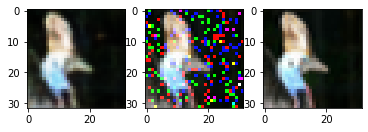

1563/1563 [==============================] - 48s 31ms/step - loss: 564.0218 - reconstruction_loss: 563.3797 - kl_loss: 0.6421 - val_loss: 600.6152 - val_reconstruction_loss: 599.9998 - val_kl_loss: 0.6154
Epoch 22/25
1563/1563 [==============================] - 44s 28ms/step - loss: 563.8466 - reconstruction_loss: 563.2071 - kl_loss: 0.6395 - val_loss: 579.7862 - val_reconstruction_loss: 579.1516 - val_kl_loss: 0.6346
Epoch 23/25
1563/1563 [==============================] - 44s 28ms/step - loss: 563.7152 - reconstruction_loss: 563.0773 - kl_loss: 0.6379 - val_loss: 580.1685 - val_reconstruction_loss: 579.5353 - val_kl_loss: 0.6331
Epoch 24/25
1563/1563 [==============================] - 43s 28ms/step - loss: 563.6176 - reconstruction_loss: 562.9809 - kl_loss: 0.6367 - val_loss: 537.5704 - val_reconstruction_loss: 536.9145 - val_kl_loss: 0.6559
Epoch 25/25
1563/1563 [==============================] - 45s 29ms/step - loss: 563.4519 - reconstruction_loss: 562.8167 - kl_loss: 0.6353 - val_

In [ ]:
denoise_vae.fit(train_dataset_noisy, epochs=25,validation_data=test_dataset_noisy,callbacks=[tensorboard_callback, CustomCallback(), model_checkpoint_callback])

In [ ]:
denoise_vae.load_weights(checkpoint_filepath)

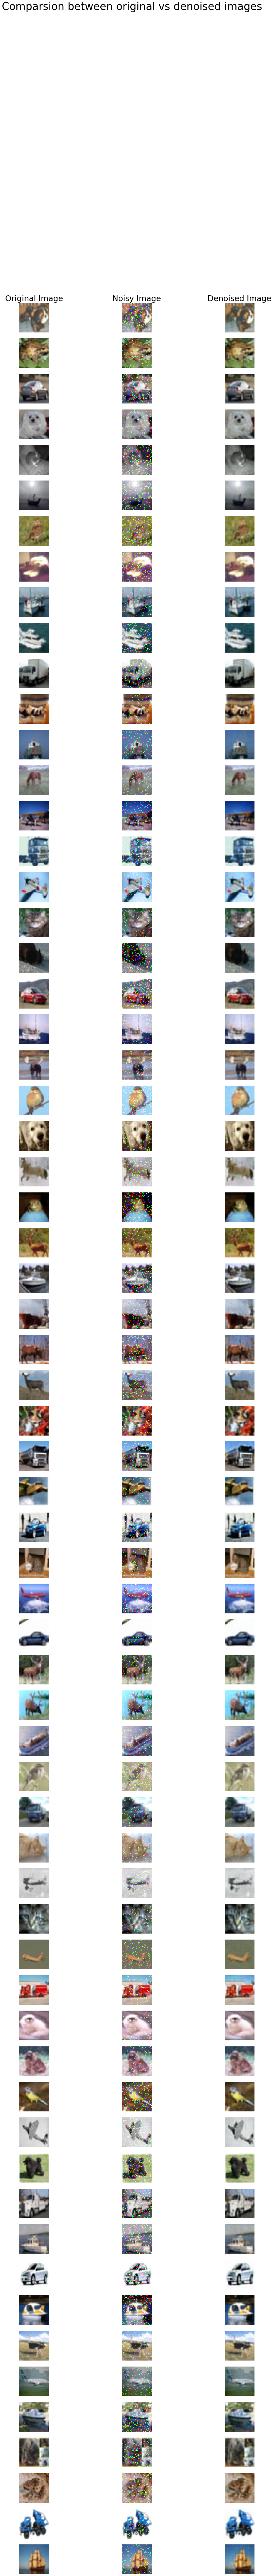

In [ ]:
#Printing results to pdf
test = test_dataset_noisy.take(1)
fig, axes = plt.subplots(nrows = batch_size,  ncols = 3, figsize = (20,160))
fig.suptitle('Comparsion between original vs denoised images', fontsize=40)
axes[0][0].set_title("Original Image", fontsize=30)
axes[0][1].set_title("Noisy Image", fontsize=30)
axes[0][2].set_title("Denoised Image", fontsize=30)
for j,i in enumerate(test):
  orig = i[1].numpy()
  noisy = i[0].numpy()
  denoised = denoise_vae(noisy)
  for k in range(batch_size):
    axes[k][0].set_axis_off()
    axes[k][1].set_axis_off()
    axes[k][2].set_axis_off()
    axes[k][0].imshow(orig[k])
    axes[k][1].imshow(noisy[k])
    axes[k][2].imshow(denoised[k])
fig.savefig('/content/drive/My Drive/dae/samples/dae1.pdf')